## Notebook for CCI-derived metabolism from scRNA-Seq using <span style="color:pink">MEBOCOST</span> in Healthy adult epithelial cells

- **Developed by**: Anna Maguza
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- 26th of June 2023

### Import packages

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

Warning (xlmhg): Failed to import "mhg_cython" C extension.
Warning (xlmhg): Failed to import the "mhg_cython" C extension.Falling back to the pure Python implementation, which is very slow.


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.9.1
scanpy      1.8.2
sinfo       0.3.4
-----
Cython              0.29.34
PIL                 9.5.0
adjustText          NA
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
comm                0.1.3
cpuinfo             NA
cycler              0.10.0
cython              0.29.34
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml         

In [3]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data upload

In [8]:
input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Cancer_dataset_integration/Datasets integration/healthy_epithelial/Integrated_Healthy_epithelial_datasets_5000.h5ad'
adata = sc.read_h5ad(input)
X_is_raw(adata)

True

In [9]:
# Extract the raw counts
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 156195 × 26442
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'Unified Cell States', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [10]:
# rename column in adata.obs 'Unified Cell States' to 'Unified_Cell_States' 
adata.obs.rename(columns = {'Unified Cell States': 'Unified_Cell_States'}, inplace = True)

#### Extract Highly Variable Genes

In [ ]:
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "Library_Preparation_Protocol",
    subset = True
)

#### Infer metabolic communications

- The mebocost.conf file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink.


In [11]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['Unified_Cell_States'],
                        met_est = 'mebocost',
                        config_path = '/Users/anna.maguza/MEBOCOST/mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[June 28, 2023 13:31:00]: We get expression data with 26442 genes and 156195 cells.
[June 28, 2023 13:31:00]: Data Preparation Done in 0.6299 seconds


#### Estimate metabolite presence


- If you just want the table of metabolic activity, you can stop here and export it as a CSV file.

In [12]:
mebo_obj._load_config_()
mebo_obj.estimator()

[June 28, 2023 13:31:01]: Load config and read data based on given species [human].
[June 28, 2023 13:31:03]: Estimtate metabolite level using mebocost


In [13]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

,AAAGCAATCCGTTGTC-1-Human_colon_16S8000511,AACACGTTCCTGCAGG-1-Human_colon_16S8000511,AACCATGGTCGGCATC-1-Human_colon_16S8000511,AACCGCGTCAACACCA-1-Human_colon_16S8000511,AACGTTGTCGGGAGTA-1-Human_colon_16S8000511,AACTCAGAGAGTCTGG-1-Human_colon_16S8000511,AACTTTCCACAACTGT-1-Human_colon_16S8000511,AACTTTCTCTTGTACT-1-Human_colon_16S8000511,AAGCCGCCAATCAGAA-1-Human_colon_16S8000511,AAGGTTCCACAGACTT-1-Human_colon_16S8000511,...,N110.LPA.TACAGTGTCCAGGGCT,N110.LPA.TACGGTATCTACTATC,N110.LPA.TACTTGTGTGTGCCTG,N110.LPA.TCATTACCAGGTTTCA,N110.LPA.TCGCGAGCACAGGTTT,N110.LPA.TCGGGACGTCAACTGT,N110.LPA.TGAGCATTCCAGTAGT,N110.LPA.TGGCCAGAGAGGACGG,N110.LPA.TTCTTAGCAGTCCTTC,N110.LPA.TTTATGCAGACTACAA
HMDB0003450,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HMDB0003948,1.375000,0.625000,1.250000,2.000000,0.0,1.250000,1.125000,2.000000,1.500000,0.625000,...,1.375000,0.625,1.125000,1.500000,0.500000,0.250000,0.750000,1.250000,0.375000,0.750000
HMDB0003712,1.300000,0.700000,1.200000,1.800000,0.0,1.200000,1.200000,1.800000,1.200000,0.900000,...,1.200000,0.500,1.500000,1.400000,0.500000,0.200000,0.700000,1.100000,0.600000,0.800000
HMDB0003945,1.666667,0.555556,1.666667,2.333333,0.0,1.222222,1.777778,2.444444,1.333333,0.666667,...,1.555556,1.000,1.333333,1.666667,0.555556,0.555556,0.888889,1.555556,0.666667,0.777778
HMDB0003949,1.375000,0.625000,1.250000,2.000000,0.0,1.250000,1.125000,2.000000,1.500000,0.625000,...,1.375000,0.625,1.125000,1.500000,0.500000,0.250000,0.750000,1.250000,0.375000,0.750000


#### MEBOCOST cell-cell communication inference

In [14]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[June 28, 2023 13:35:59]: Load config and read data based on given species [human].
[June 28, 2023 13:36:04]: Estimtate metabolite level using mebocost
[June 28, 2023 13:36:55]: Infer communications
[June 28, 2023 13:36:55]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[June 28, 2023 13:36:55]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[June 28, 2023 13:43:24]: met_sensor: (350, 8)
[June 28, 2023 13:43:24]: avg_exp: (2166, 12) for (gene, cell) of needed
[June 28, 2023 13:43:24]: avg_met: (592, 12) for (metabolite, cell) of needed
[June 28, 2023 13:43:24]: shuffling 1000 times for generating backgroud
[June 28, 2023 13:44:25]: take exp and met avg for shuffling
[June 28, 2023 13:48:00]: thread: 4
[June 28, 2023 13:48:04]: ABCA1 ~ HMDB0006247
[June 28, 2023 13:48:04]: Normalizing Cluster Mean and Calculating Communication Score
[June 28, 2023 13:48:04]: Calculating P-value
[June 28, 2023 13:48:05]: SLC7A1 ~ HMDB0000517
[June 28, 2023 13:48:05]:

In [15]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 1.0
metabolite_presence cutoff: 0.1666666716337204


In [18]:
# Save results
commu_res.to_csv('/Users/anna.maguza/Desktop/GCA_social_network/8_cell-cell_interactions/Healthy_reference/mebocost/Healthy_epithelial_mebocost_results.csv')

#### Visualise MEBOCOST prediction

- Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

In [21]:
adata.obs['Unified_Cell_States'].value_counts()

Enterocyte                56398
TA                        40570
Stem cells                27658
Goblet cells              13051
Colonocyte                11707
Paneth cells               3468
Tuft cells                 1204
Epithelial cells           1141
Microfold cell              340
Enteroendocrine cells       311
L cells                     228
Enterochromaffin cells      119
Name: Unified_Cell_States, dtype: int64

[June 28, 2023 13:59:07]: plot heatmap for significant result


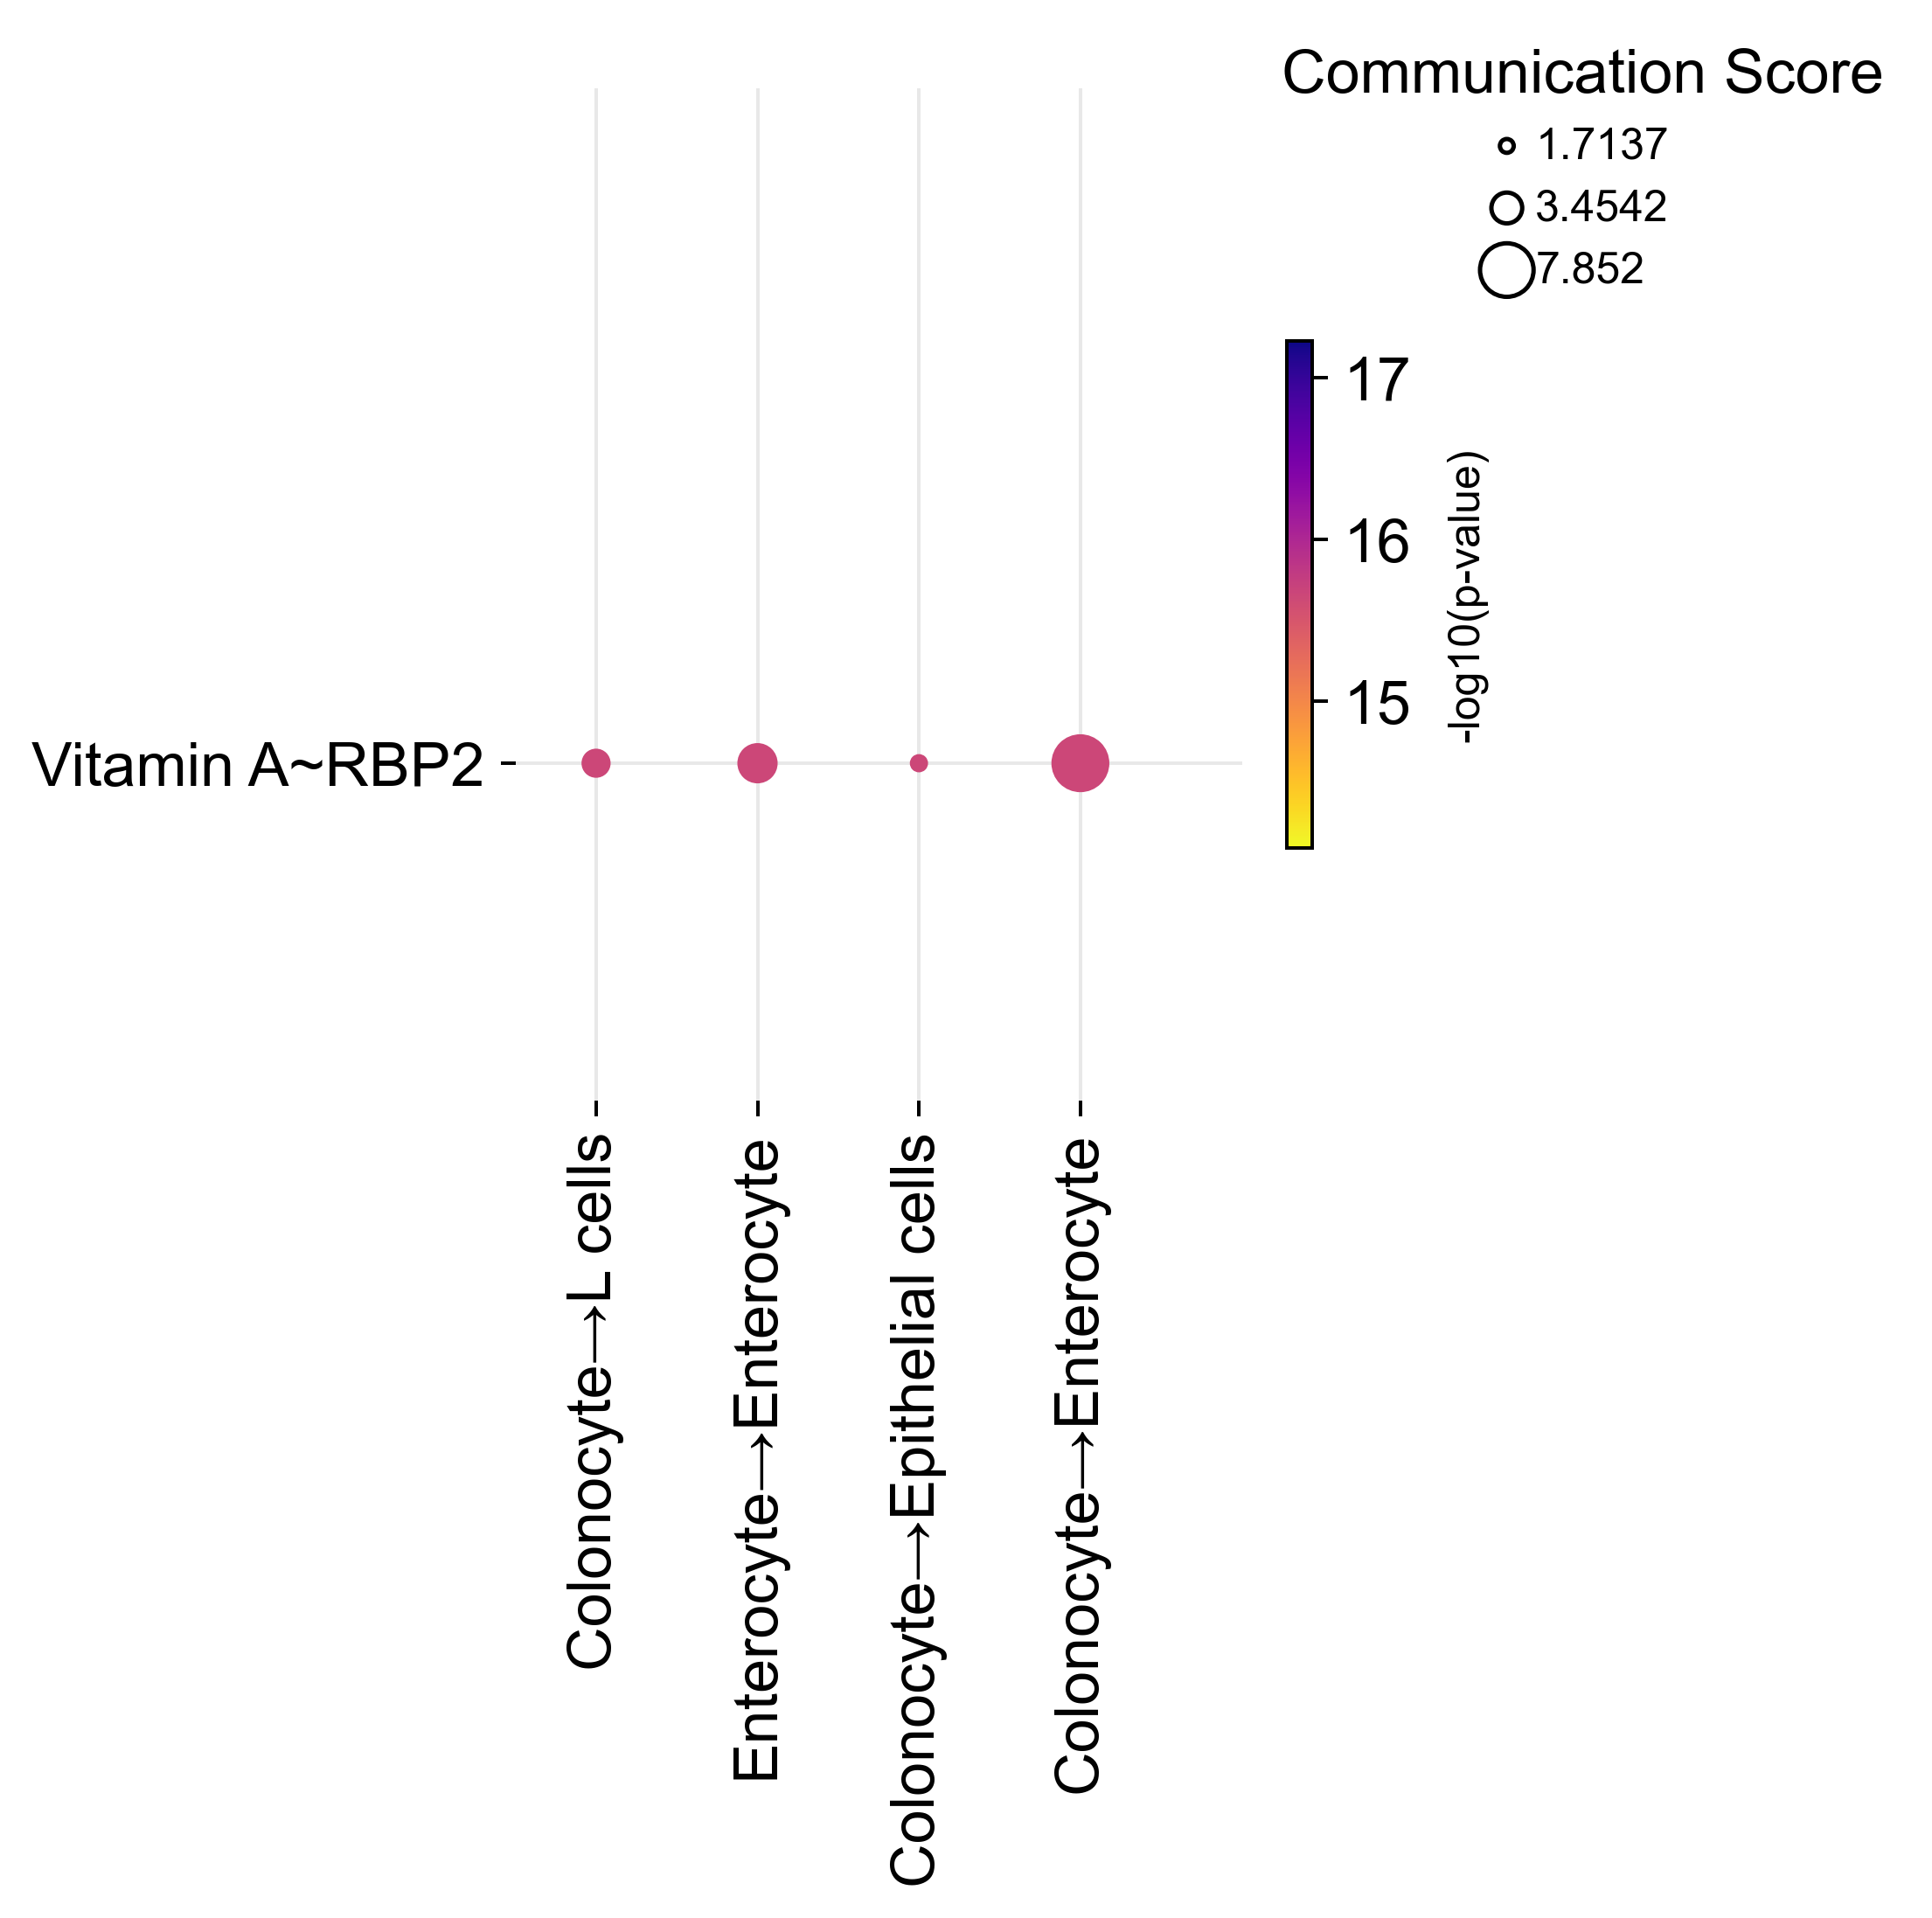

In [24]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )


[June 29, 2023 15:24:06]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


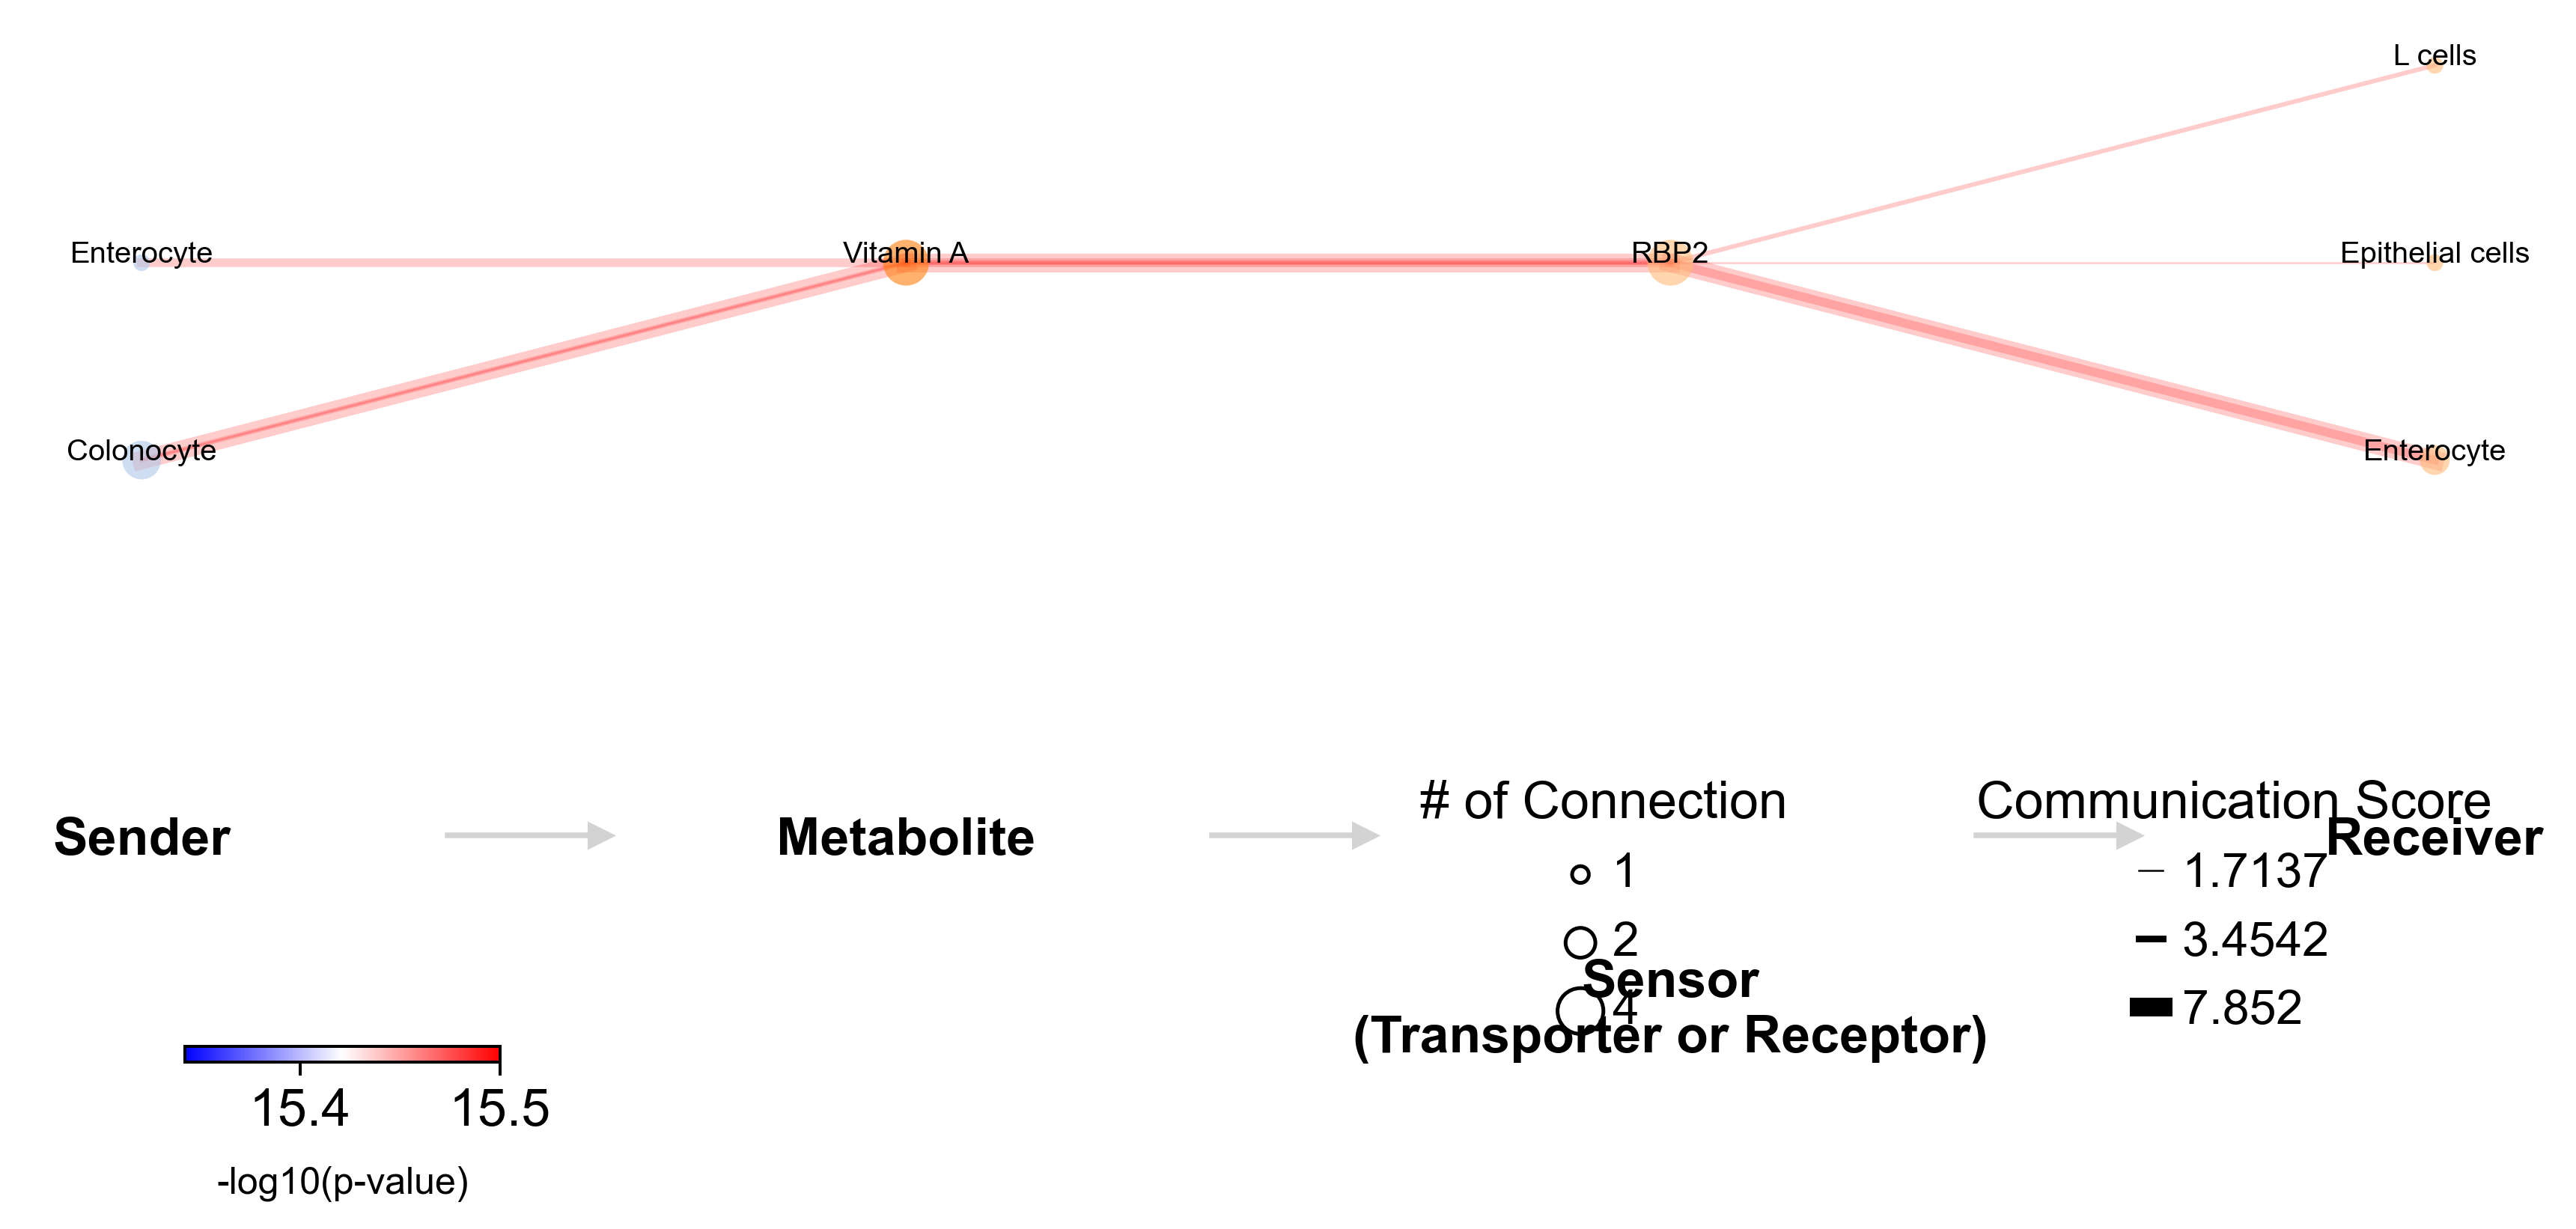

In [26]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )